# Treasure Hunt Game Notebook

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains the maze object (8x8 matrix)

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

Helper function for visual representation of maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
# Constants
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor (exploration:exploitation)
epsilon = 0.5  # sets to 0.05 (no decay) once win rate is 90+%

# Actions dictionary
actions_dict = {
    LEFT:  'left',
    UP:    'up',
    RIGHT: 'right',
    DOWN:  'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


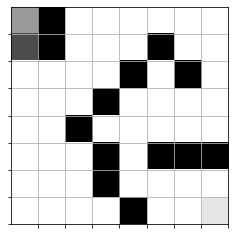

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    # Sequential: linear stack of layers
    model = Sequential()
    # dense input layer: input_shape=maze.size
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    # PReLU (Parametric ReLU) activation function for non-linearity & complex learning
    model.add(PReLU())
    # dense hidden layer: size = maze.size
    model.add(Dense(maze.size))
    # PReLu activation layer
    model.add(PReLU())
    # dense output layer: number of units = num_actions
    model.add(Dense(num_actions))  # predicts best action in a given state
    # Adam optimizer: adaptive (dynamic) learning rate optimizer
    # MSE (Mean Squared Error) loss function: estimates continous Q-values (regression)
    model.compile(optimizer='adam', loss='mse')
    # return built model
    return model

# #Q-Training Algorithm

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # fetches 'opt' dict's key value. If key doesn't exist, returns default value of 15000
    n_epoch = opt.get('n_epoch', 15000)  # max number of epochs (iterations) over training dataset

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Experience replay improves learning by using a random subset of experiences
    # and breaks correlation between consecutive learning steps to lead to more stable convergence
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size // 2   # history window size
    win_rate = 0.0
    
    print(
        '******************************\n' +
        '********** Starting **********\n' +
        '******************************\n' +
        '\nPlease wait...\n')
    
    # For each epoch:
    for epoch in range(n_epoch):  # number of epochs (iterations) over training dataset
        loss = 0.0
        
        # agent_cell = randomly select a free cell
        agent_cell = random.choice(qmaze.free_cells)
        
        # Reset the maze with agent set to random free cell
        qmaze.reset(agent_cell)
        
        # Initial observation of the environment's state after resetting the maze
        envstate = qmaze.observe()
    
        game_status = 'not_over'
        game_over = False
        n_episodes = 0
    
        # While state is not game over:
        while not game_over:

            # Get available actions based on board position
            valid_actions = qmaze.valid_actions()
            
            # Break loop if no valid actions
            if not valid_actions:
                break

            if np.random.rand() < epsilon:
                # Exploration: choose a random action
                # to avoid local optima and find global optimum (new better actions)
                action = random.choice(valid_actions)
            
            else:
                # Exploitation: choose the action with the highest Q-value for the current state
                action = np.argmax(experience.predict(envstate))  # value function
                # (Q) value function: Q_sa = np.max(self.predict(envstate_next))
                
            previous_envstate = envstate
            envstate, reward, game_status = qmaze.act(action)

            # tally each win
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            
            else:  # 'not_over'
                game_over = False  # game still going
            
            episode = [
                previous_envstate,
                action,
                reward,
                envstate,
                game_over
            ]
    
            # Store episode in Experience replay object
            experience.remember(episode)
            n_episodes += 1
            
            inputs, targets = experience.get_data(data_size=data_size)
            
            #TODO Train neural network model
            model.fit(
                inputs,         # input data to the model
                targets,        # target data (or labels) the model should learn to predict
                epochs=16,      # number of epochs to train the AI model on each game iteration
                batch_size=16,  # number of samples per gradient update for training
                verbose=0       # 0 = silent, 1 = progress bar, 2 = one line per epoch
            )

            # Determine loss
            loss = model.evaluate(
                inputs,
                targets,
                verbose=0
            )
            
        # Print the epoch, loss, episodes, win count, and win rate (for each epoch)
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # Epoch is over if win rate is above threshold and model passes the completion check
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        if win_rate > 0.9 : epsilon = 0.05  # hard lowers explore rate from 0.1 to 0.05 once 90% games won       # Checks if training has exhausted all free cells & if agent won 100%.
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
            
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds  # t (seconds) value will be printed to console due to being last assigned value

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

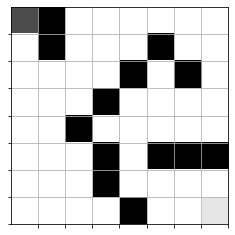

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32)

******************************
********** Starting **********
******************************

Please wait...

Epoch: 000/999 | Loss: 0.0022 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 37.2 seconds
Epoch: 001/999 | Loss: 0.0264 | Episodes: 159 | Win count: 0 | Win rate: 0.000 | time: 78.8 seconds
Epoch: 002/999 | Loss: 0.0350 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 116.6 seconds
Epoch: 003/999 | Loss: 0.0033 | Episodes: 3 | Win count: 1 | Win rate: 0.000 | time: 117.5 seconds
Epoch: 004/999 | Loss: 0.0051 | Episodes: 149 | Win count: 1 | Win rate: 0.000 | time: 156.9 seconds
Epoch: 005/999 | Loss: 0.0021 | Episodes: 8 | Win count: 2 | Win rate: 0.000 | time: 159.1 seconds
Epoch: 006/999 | Loss: 0.0203 | Episodes: 78 | Win count: 3 | Win rate: 0.000 | time: 179.7 seconds
Epoch: 007/999 | Loss: 0.0050 | Episodes: 148 | Win count: 3 | Win rate: 0.000 | time: 218.9 seconds
Epoch: 008/999 | Loss: 0.0016 | Episodes: 148 | Win count: 3 | Win rate: 0.000 | time: 24

791.66964

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

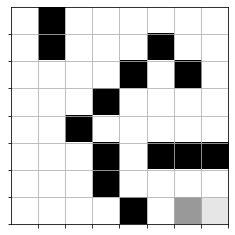

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

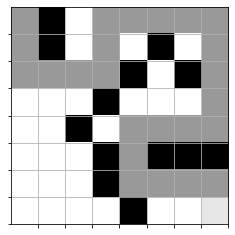

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)